# Generalized Metric Learning on Manifolds
`Drew Wilimitis`

![title](images/ex_manifolds.png)

**Note:** This is my attempt to implement and potentially expand on the methods outlined in "Metric Learning on Manifolds" **[1]**, which was implemented by the authors here (https://github.com/m-k-S/manifold_ml)

### Import libraries and load data

In [5]:
# import libraries
import numpy as np
import matplotlib
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.style.use('default')
import seaborn as sns
import time
import sys
import os

# import modules within repository
my_path = 'C:\\Users\\dreww\\Desktop\\manifold-metric-learn' # path to utils folder
sys.path.append(my_path)
from example_manifolds import *
from distance_approx import *

# ignore warnings
import warnings
warnings.filterwarnings('ignore');

# display multiple outputs within a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all";

## Generalized Surface Manifolds and Distance Approximation

We restrict our approach to **generalized surfaces** that are globally *diffeomorphic* to an open subset of Euclidean space. Two topological spaces are *diffeomorphic* if there exists a smooth bijection with a smooth inverse between them.<br>

This allows us to frequently define our $d$-dimensional, general surface manifold $S \subset \mathbb{R}^{D}$ in terms of a base space $B \subset \mathbb{R}^{d}$ and the diffeomorphism $F,$ i.e. $S=\{F(x): x \in B\}$. <br>

Although $S$ is in ambient Euclidean space $\mathbb{R}^{D}$, it does not necessarily inherit the ambient metric structure, and so it is significantly easier in theory and implementation to substitute points $x, y \in S$ with $F(b_1), F(b_2)$ 

### Example Manifold Surfaces

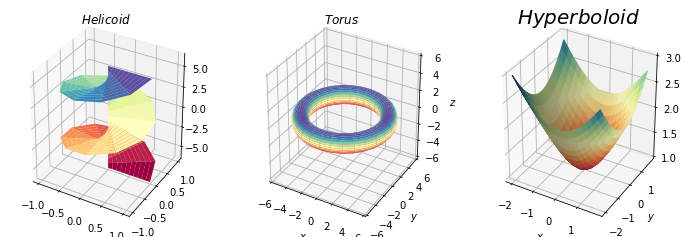

In [2]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 3, 1, projection='3d')
plot_helicoid(current_ax=ax)
ax = fig.add_subplot(1, 3, 2, projection='3d')
plot_torus(current_ax=ax)
ax = fig.add_subplot(1, 3, 3, projection='3d')
plot_hyperboloid(current_ax=ax)
plt.savefig('images/ex_manifolds.png')
plt.show();

### Manifold Distance Approximation Algorithm

To approximate the distance between $x, y \in S$, we refer to the base space and consider a set of intermediate points in $B$ given by $F^{-1}(x)=a_{0}, a_{1}, \ldots, a_{n}, a_{n+1}=F^{-1}(y)$

We have the manifold distance along an intermediate path:

$$
\sigma\left(a_{i}, a_{i+1}\right):=\int_{0}^{1} \sqrt{\left\langle\frac{d}{d t} F(\bar{\kappa}(t)), \frac{d}{d t} F(\bar{\kappa}(t))\right\rangle} d t
$$

where the straight line path between successive intermediate points is given by $\bar{\kappa}(t)=(1-t) a_{i}+t a_{i+1}$ <br>

**Note:** Assumes $B$ is convex

![title](images/dist_alg.png)

In [6]:
from scipy import integrate
def approximate_distance(a, b, integrand, L=None, n=7, m=50, tol=1e-6):
    """
    Approximate manifold distance between the diffeomorphic mappings F(a)=x and F(b)=y 
    Parameters
    ----------
    a : F^-1 (x), point in Euclidean base space B, initial point in linear sequence a0, ..., a_n+1
    b : F^-1 (y), point in Euclidean base space B, endpoint of linear sequence a0, ..., a_n+1
    L : optional linear transformation matrix L applied to B, if none use identity matrix
    n : number of intermediate points between a,b in sequence a0, a1, ..., a_n+1
    m : number of bi sampled from base space at each intermediate point
    """
    base_dim = len(a)
    if L == None:
        L = np.eye(base_dim)
    if not (len(a) == len(b) == L.shape[0]):
        print('Input dimensions do not match!')
        return
    
    # create list with sequence a0, ..., a_n+1 of linearly spaced intermediate points
    linear_seq = []
    linear_seq.append(a)
    for i in range(n):
        delta = (i + 1) / (n + 1) * (b - a)
        linear_seq.append(a + delta)
    linear_seq.append(b)
    
    convergence = True
    while convergence is True:
        convergence = False
        
        for i, alpha in enumerate(linear_seq[1:-1]):
            index = i + 1
            current_pt = alpha
            prev_pt = linear_seq[index - 1]
            next_pt = linear_seq[index + 1]
            
            # arc length integrals
            length_1 = integrate.quad(integrand, 0, 1, args=(prev_pt, current_pt))[0] 
            length_2 = integrate.quad(integrand, 0, 1, args=(current_pt, next_pt))[0] 
            
            radius = 2. * max(np.linalg.norm(current_pt - prev_pt), np.linalg.norm(next_pt - current_pt))
            samples = np.random.uniform(-radius, radius, size=(m, base_dim)) + alpha # radius ball centered at alpha
            min_dist = length_1 + length_2
            best_pt = current_pt

            # find min intermediate path distance and update values
            for sample_pt in samples:
                length_1 = integrate.quad(integrand, 0, 1, args=(prev_pt, current_pt))[0]
                length_2 = integrate.quad(integrand, 0, 1, args=(current_pt, next_pt))[0] 
                sample_dist = length_1 + length_2
                if sample_dist < min_dist:
                    min_dist = sample_dist
                    best_pt = sample_pt
            linear_seq[i] = best_pt

            # if any updates aren't less than the tolerance, continue while loop
            if not np.linalg.norm(current_pt - best_pt) < tol:
                convergence = True
                
    total_dist = 0
    for i in range(len(linear_seq)-1):
        path_dist = integrate.quad(integrand, 0, 1, args=(linear_seq[i], linear_seq[i+1]))[0]
        total_dist += path_dist

    return total_dist

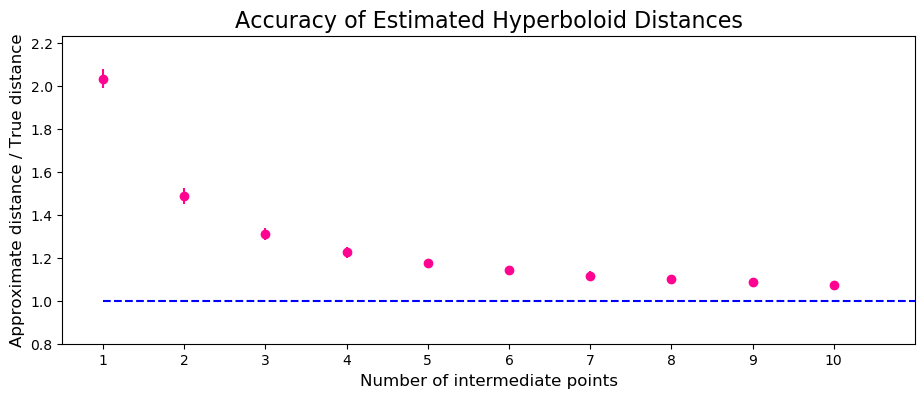

In [7]:
def test_approximations(n_samples, parameter_n_range):
    n_trials = len(parameter_n_range)
    s = np.random.uniform(-2, 2, size=(n_samples, 2))
    r = np.random.uniform(-2, 2, size=(n_samples, 2))
    result_dict = {}
    for n in parameter_n_range:
        errors = []
        for i in range(n_samples):
            x = hyperboloid_map(r[i])
            y = hyperboloid_map(s[i])
            true_dist = hyperboloid_dist(x, y)
            errors.append(approximate_distance(s[i], r[i], integrand_hyperboloid, n=n, m=10) / true_dist)
        result_dict[n] = errors
    return result_dict

params = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
scores = test_approximations(5, params)

mean_ratios = []
std_dev = []
for item in scores.values():
    mean_ratios.append(1/np.mean(item))
    std_dev.append(np.std(item))

plt.figure(figsize=(11,4))
plt.style.use('default')
plt.errorbar(np.arange(1, len(params)+1), mean_ratios, yerr=std_dev, fmt='o', color='#ff0490')
ax = plt.gca()
ax.set_xticks(np.arange(1, len(params)+1))
plt.ylabel('Approximate distance / True distance', size=12)
plt.xlabel('Number of intermediate points', size=12)
plt.title('Accuracy of Estimated Hyperboloid Distances', size=16)
plt.ylim(0.8, np.max(mean_ratios)+0.2)
plt.xlim(0.5, len(params)+1)
plt.plot([1, len(params)+1], [1, 1], 'b--')
plt.show();

## Mahalanobis Metric for Clustering (MMC)

MMC involves finding an optimal linear transformation that groups similar data points (set $P$) together and pushes dissimilar data points (set $Q$) further away. The standard MMC optimization problem is given as: 

$$
\min _{L \in \mathbb{R}^{d \times d}} \underbrace{\sum_{\left(x_{i}, x_{j}\right) \in P}\left\|L x_{i}-L x_{j}\right\|^{2}}_{\text {pull term }} -\lambda \underbrace{\sum_{\left(x_{i}, x_{j}\right) \in Q}\left\|L x_{i}-L x_{j}\right\|^{2}}_{\text {push term }}
$$
<br>
and for manifolds we have a linear transformation $L$ applied to $B$ with the manifold distance

$$
\rho_{L}^{F}\left(x_{i}, x_{j}\right):=\rho^{F}\left(F\left(L b_{i}\right), F\left(L b_{j}\right)\right)
$$

We can rewrite the optimization problem for generalized manifolds:

$$
\min _{L \in \mathbb{R}^{d \times d}} \sum_{\left(x_{i}, x_{j}\right) \in P} \rho_{L}^{F}\left(x_{i}, x_{j}\right)-\lambda \sum_{\left(x_{i}, x_{j}\right) \in Q} \rho_{L}^{F}\left(x_{i}, x_{j}\right)
$$

In [8]:
from scipy.optimize import minimize

def similar_pairs(labels):
    """ Generate similarity/dissimilarity pair sets based on indices with the same label """
    P = [] # set of similar pairs
    Q = [] # set of dissimilar pairs
    n = len(labels)
    for i in range(n):
        for j in range(i+1, n):
            if labels[i] == labels[j]:
                P.append([i, j])
            else:
                Q.append([i, j])
    return P, Q

def mmc_loss(L, B, labels, manifold_map_fn, integrand, manifold_dist_fn=None, C=0.1, scaling_penalty=10):
    """
    Function to calculate the MMC loss for generalized manifold surfaces
    Parameters
    ----------
    L : optimization argument we seek to find, linear transformation matrix L applied to B
    B : set of m points b1, ..., bm in Euclidean base space
    labels : set of m classification labels y1, ..., ym
    manifold_map_fn : function F that maps points in B to manifold S
    manifold_dist_fn : explicit distance function on the manifold, if none then approximate
    integrand: arc length formula for piecewise linear distance approximation
    C: constant parameter controlling degree of push/pull in optimization routine 
    """
    
    # to use explicit manifold distance formulas, need to get manifold points by applying F to B
    dim = len(B[0])
    L = L.reshape(dim, dim)
    X = []
    for b in B:
        X.append(manifold_map_fn(np.matmul(L, b)))
    
    # get similarity pair indices
    similar_ix, dissimilar_ix = similar_pairs(labels)
    
    # get first summation term
    push = 0
    for i, j in similar_ix:
        if manifold_dist_fn == None: # approximation method
            d_ij = approximate_distance(np.matmul(L, B[i]), np.matmul(L, B[j]), integrand=integrand, n=3, m=1, tol=0.01)
        else:
            d_ij = manifold_dist_fn(X[i], X[j])
        push += (1 - C) * d_ij / len(similar_ix)
            
    # get second summation term
    pull = 0
    for i, j in dissimilar_ix:
        if manifold_dist_fn == None: # approximation method
            d_ij = approximate_distance(np.matmul(L, B[i]), np.matmul(L, B[j]), integrand=integrand, n=4, m=10, tol=0.001)
        else:
            d_ij = manifold_dist_fn(X[i], X[j])
        pull += C * d_ij / len(dissimilar_ix)
    
    loss = push - pull + scaling_penalty*(np.matmul(L.T, L).sum())
    return loss

def mmc_optimize(B, labels, manifold_map_fn, integrand, solver='Powell', max_eval=50, summary=False):
    """
    Wrapper for scipy optimization routine, return linear transformation matrix L that minimizes mmc loss
    Parameters
    ----------
    B : set of m points b1, ..., bm in Euclidean base space
    labels : set of m classification labels y1, ..., ym
    manifold_map_fn : function F that maps points in B to manifold S
    integrand: arc length formula for piecewise linear distance approximation
    solver: scipy minimization method (Powell, Nelder-Mead, Newton-CG)
    max_eval: limit on number of loss function evaluations
    """
    dim = len(B[0])
    L_init = np.eye(dim)
    manifold_opt_L = minimize(mmc_loss, L_init,
                          args=(B, labels, manifold_map_fn, integrand),
                          method=solver, options={'disp': True, 'maxfev': max_eval})
    if summary:
        print(manifold_opt_L)
    L_new = manifold_opt_L.x.reshape(dim,dim)
    return L_new

### Ex.) Hyperboloid

In [9]:
hyp_sample = np.array([np.random.uniform(-1, 1, 10), np.random.uniform(-1, 1, 10)]).T
hyp_labels = [int(x) for x in hyp_sample[:,1] < 0]
hyp_L = mmc_optimize(hyp_sample, hyp_labels, hyperboloid_map, integrand_hyperboloid, summary=True)

   direc: array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])
     fun: 0.3133182784897334
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 91
     nit: 2
  status: 1
 success: False
       x: array([-0.00191456,  0.00191771, -0.97527754,  0.97685994])


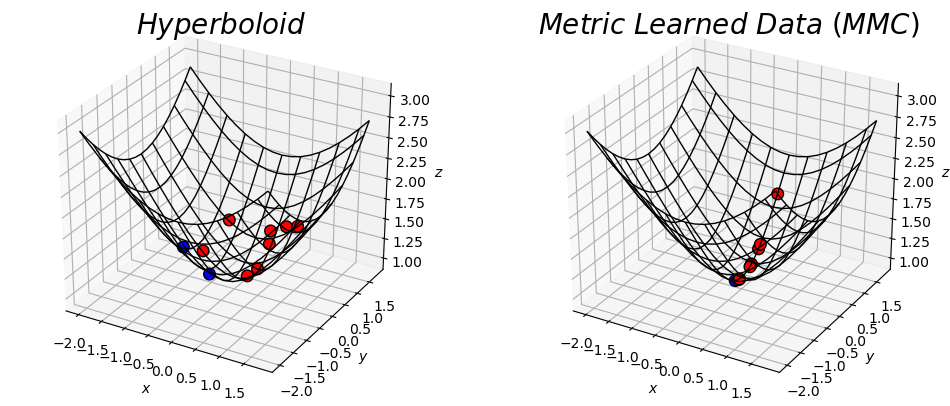

In [10]:
from mpl_toolkits.mplot3d import Axes3D
fig=plt.figure(figsize=(12,5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
hyp_pts = np.array([hyperboloid_map(s) for s in hyp_sample])
colors = ['red', 'blue']
ax.scatter(hyp_pts[:,0], hyp_pts[:,1], hyp_pts[:,2], c=[colors[x] for x in hyp_labels], s=70, edgecolor='black', alpha=1)
plot_hyperboloid(style='wireframe', current_ax=ax)

hyp_mmc = np.array([hyperboloid_map(np.matmul(hyp_L, s)) for s in hyp_sample])
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter(hyp_mmc[:,0], hyp_mmc[:,1], hyp_mmc[:,2],
           c=[colors[x] for x in hyp_labels], s=70, edgecolor='black', alpha=1)
plot_hyperboloid(style='wireframe', current_ax=ax, title='$Metric \ Learned \ Data \ (MMC)$')
plt.savefig('images/hyperboloid_mmc.png')
plt.show();

### Ex.) Helicoid

In [11]:
heli_sample = np.array([np.random.uniform(0, 1, 10), np.random.uniform(-np.deg2rad(360), np.deg2rad(360), 10)]).T
heli_labels = [int(x) for x in heli_sample[:,1] < 0]
heli_L = mmc_optimize(heli_sample, heli_labels, helicoid_map, integrand_helicoid, summary=True)

   direc: array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])
     fun: 0.39289609448925555
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 81
     nit: 2
  status: 1
 success: False
       x: array([-5.25661829e-04,  2.90831505e-04, -9.81140780e-01,  9.59774116e-01])


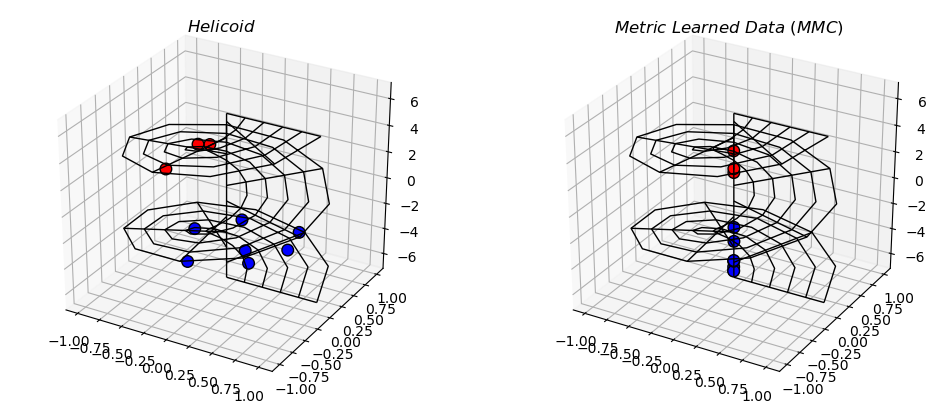

In [12]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
heli_pts = np.array([helicoid_map(s) for s in heli_sample])
ax.scatter(heli_pts[:,0], heli_pts[:,1], heli_pts[:,2], 
           c=[colors[x] for x in heli_labels], s=70, edgecolor='black', alpha=1)
plot_helicoid(style='wireframe', current_ax=ax)

heli_mmc = np.array([helicoid_map(np.matmul(heli_L, s)) for s in heli_sample])
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter(heli_mmc[:,0], heli_mmc[:,1], heli_mmc[:,2],
           c=[colors[x] for x in heli_labels], s=70, edgecolor='black', alpha=1)
plot_helicoid(style='wireframe', current_ax=ax, title='$Metric \ Learned \ Data \ (MMC)$')
plt.savefig('images/helicoid_mmc.png')
plt.show();

### Large Margin Nearest Neighbor (LMNN) for Improved Nearest Neighbors Classification

Rather than considering global relationships like in MMC, LMNN attempts to maximize local similarities defined by the neighbor relationship $x_i \sim x_j$ and minimize local classification dissimilarities denoted by $x_l \succ x_i$. Instead of pairs, we consider triples $(i, j, l)$ <br>

$$
\min _{L \in \mathbb{R}^{d \times d}} \underbrace{\sum_{i, j \sim i} \rho_{L}^{F}\left(x_{i}, x_{j}\right)}_{\text {pull term on } S}+\lambda \underbrace{\sum_{i, j \sim i, l \succ i}\left[1+\rho_{L}^{F}\left(x_{i}, x_{j}\right)-\rho_{L}^{F}\left(x_{i}, x_{l}\right)\right]_{+}}_{\text {push term on } S}
$$ 

with hinge loss on the second term: $[\cdot]+:=\max (\cdot, 0)$

In [56]:
def nearest_neighbors_x(bi, B, labels, manifold_map_fn, integrand, k, L=None, radius=None, manifold_dist_fn=None):
    """ Return the index set of true neighbors and imposter neighbors for a given data point x = F(Lbi) """
    # check input linear transformation matrix
    base_dim = len(B[0])
    if L is None:
        L = np.eye(base_dim)
        
    # get all distances in the manifold to point x
    distances = []
    if manifold_dist_fn == None:
        for index, bj in enumerate(B):
            distances.append(approximate_distance(bi, bj, integrand=integrand))
            # get label of point x
            if np.array_equal(bj, bi):
                xi_label = labels[index]
            
    else:
        xi = manifold_map_fn(np.matmul(L, bi))
        for index, bj in enumerate(B):
            xj = manifold_map_fn(np.matmul(L, bj))
            distances.append(manifold_dist_fn(xi, xj))
            # get label of point x
            if np.array_equal(bj, bi):
                xi_label = labels[index]
            
    # sort indices and get closest k neighbors (excluding oneself)
    top_k = np.argsort(distances)[1:k+1]
    
    # use labels to find index set of true neighbors and of imposter neighbors
    imposter_index = []
    true_neighbors_index = []
    for index in top_k:
        if labels[index] == xi_label:
            true_neighbors_index.append(index)
        else:
            imposter_index.append(index)
    return true_neighbors_index, imposter_index

In [57]:
hyp_sample = np.array([np.random.uniform(-1, 1, 20), np.random.uniform(-1, 1, 20)]).T
hyp_labels = np.random.randint(0, 2, 20)
indx_neighbors, indx_imposters = nearest_neighbors_x(hyp_sample[0], hyp_sample, hyp_labels, hyperboloid_map, integrand_hyperboloid, k=7)
indx_outside = [x for x in range(len(hyp_labels)) if x not in indx_neighbors + indx_imposters]

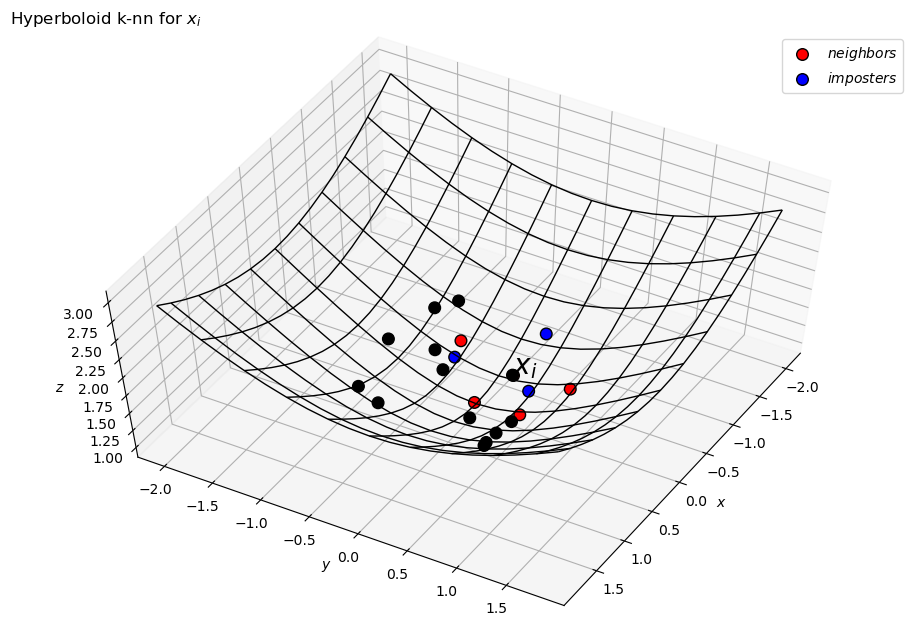

In [58]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(9,6))
ax = Axes3D(fig)
hyp_pts = np.array([hyperboloid_map(s) for s in hyp_sample])
ax.scatter(hyp_pts[0,0], hyp_pts[0,1], hyp_pts[0,2], color='red', s=70, edgecolor='black', alpha=1)
ax.text(hyp_pts[0,0], hyp_pts[0,1], hyp_pts[0,2]+0.02, s='$x_i$', size=20, fontweight='bold')

ax.scatter(hyp_pts[indx_outside,0], hyp_pts[indx_outside,1], hyp_pts[indx_outside,2], color='black', s=70, edgecolor='black', alpha=1)
ax.scatter(hyp_pts[indx_neighbors,0], hyp_pts[indx_neighbors,1], hyp_pts[indx_neighbors,2], color='red', s=70, edgecolor='black', alpha=1, label='$neighbors$')
ax.scatter(hyp_pts[indx_imposters,0], hyp_pts[indx_imposters,1], hyp_pts[indx_imposters,2], color='blue', s=70, edgecolor='black', alpha=1, label='$imposters$')
plot_hyperboloid(style='wireframe', current_ax=ax, title=None)
plt.title('Hyperboloid k-nn for $x_i$', loc='left')
ax.view_init(60, 30);
plt.legend(loc='best');
plt.savefig('images/hyperboloid_knn.png');

In [ ]:

########## NEED TO OPTIMIZE

def lmnn_loss(L, B, labels, manifold_map_fn, integrand, manifold_dist_fn=None, C=0.1, scaling_penalty=10):
    """
    Function to calculate the LMNN loss for generalized manifold surfaces
    Parameters
    ----------
    L : optimization argument we seek to find, linear transformation matrix L applied to B
    B : set of m points b1, ..., bm in Euclidean base space
    labels : set of m classification labels y1, ..., ym
    manifold_map_fn : function F that maps points in B to manifold S
    manifold_dist_fn : explicit distance function on the manifold, if none then approximate
    integrand: arc length formula for piecewise linear distance approximation
    C: constant parameter controlling degree of push/pull in optimization routine 
    """
    # to use explicit manifold distance formulas, need to get manifold points by applying F to B
    dim = len(B[0])
    L = L.reshape(dim, dim)
    X = []
    for b in B:
        X.append(manifold_map_fn(np.matmul(L, b)))
        
    for i, bi in enumerate(B):
        # get indices of true neighbors, imposters for xi = F(L*bi)             
        indx_neighbors, indx_imposters = nearest_neighbors_x(bi, B, labels, manifold_map_fn, integrand, k=5, L=L)

        # get first summation term
        pull = 0
        for j in indx_neighbors:
            if manifold_dist_fn == None: # approximation method
                d_ij = approximate_distance(np.matmul(L, bi), np.matmul(L, B[j]), integrand=integrand, n=3, m=1, tol=0.01)
            else:
                d_ij = manifold_dist_fn(X[i], X[j])
            pull += (1 - C) * d_ij / len(indx_neighbors)
            
        # get second summation term
        push = 0
        for j in indx_neighbors:
            if manifold_dist_fn == None: # approximation method
                d_ij = approximate_distance(np.matmul(L, B[i]), np.matmul(L, B[j]), integrand=integrand, n=3, m=1, tol=0.01)
            else:
                d_ij = manifold_dist_fn(X[i], X[j])
                
            for l in indx_imposters:
                if manifold_dist_fn == None: # approximation method
                    d_il = approximate_distance(np.matmul(L, B[i]), np.matmul(L, B[l]), integrand=integrand, n=3, m=1, tol=0.01)
                else:
                    d_il = manifold_dist_fn(X[i], X[l])
                # hinge loss
                hinge_loss = np.max(1 + d_ij - d_il, 0)
                push += C * hinge_loss
    
    loss = pull - push + scaling_penalty*(np.matmul(L.T, L).sum())
    return loss

In [ ]:
def lmnn_optimize(B, labels, manifold_map_fn, integrand, solver='Powell', max_eval=10, summary=False):
    """
    Wrapper for scipy optimization routine, return linear transformation matrix L that minimizes mmc loss
    Parameters
    ----------
    B : set of m points b1, ..., bm in Euclidean base space
    labels : set of m classification labels y1, ..., ym
    manifold_map_fn : function F that maps points in B to manifold S
    integrand: arc length formula for piecewise linear distance approximation
    solver: scipy minimization method (Powell, Nelder-Mead, Newton-CG)
    max_eval: limit on number of loss function evaluations
    """
    dim = len(B[0])
    L_init = np.eye(dim)
    manifold_opt_L = minimize(lmnn_loss, L_init,
                          args=(B, labels, manifold_map_fn, integrand),
                          method=solver, options={'disp': True, 'maxfev': max_eval})
    if summary:
        print(manifold_opt_L)
    L_new = manifold_opt_L.x.reshape(dim,dim)
    return L_new

In [ ]:
hyp_sample = np.array([np.random.uniform(-1, 1, 10), np.random.uniform(-1, 1, 10)]).T
hyp_labels = [int(x) for x in hyp_sample[:,1] < 0]
#lmnn_loss(np.random.uniform(0, 1, size=(2,2)), hyp_sample, hyp_labels, hyperboloid_map,
#          integrand_hyperboloid, manifold_dist_fn=hyperboloid_dist, C=0.1, scaling_penalty=10)

lmnn_optimize(hyp_sample, hyp_labels, hyperboloid_map, integrand_hyperboloid, summary=True)

# References
___

**1.]** Aalto, M., & Verma, N. (2019). Metric Learning on Manifolds. ArXiv, abs/1902.01738 